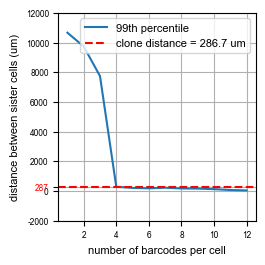

In [6]:
# Import required libraries
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.spatial.distance as sci_dist
from PIL import Image
import numpy as np
# Configure matplotlib and numpy settings
# matplotlib.use('QtAgg')
Image.MAX_IMAGE_PIXELS = None
np.random.seed(0)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

tools_path = '../helperScripts/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

# Define file paths
data_folder = tools.roi_file_paths['dish_roi2']['out_path']
# data_folder = '/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_2/exports'
region_data_path = '../extractedData/in_vitro/Region_Data_with_Minimal_Values.csv'
# region_data_path = '/Users/YaelHeyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/processedData/Region_Data_with_Minimal_Values.csv'
cell_by_gene_path = os.path.join(data_folder, 'cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.2thresh.csv')
data_output_folder = '../extractedData/in_vitro'
plot_output_folder = '../graphs'

def calculate_polygon_area(vertices):
    """Calculate the area of a polygon given its vertices as a NumPy array.
    
    Arguments:
    vertices -- a NumPy array of shape (N, 2), where N is the number of vertices
    
    Returns:
    The area of the polygon.
    """
    # Ensure the first vertex is also the last (to close the polygon)
    if not np.array_equal(vertices[0], vertices[-1]):
        vertices = np.vstack([vertices, vertices[0]])
    
    # Calculate the sum of the cross-products
    x0 = vertices[:-1, 0]
    y1 = vertices[1:, 1]
    y0 = vertices[:-1, 1]
    x1 = vertices[1:, 0]
    
    # Calculate the area using the shoelace formula
    area = abs(np.sum(x0 * y1) - np.sum(y0 * x1)) / 2.0
    return area

def max_dist(coords, ids):
    """Calculate maximum distance between points and enclosed area.
    
    Arguments:
    coords -- coordinate array
    ids -- indices of points to consider
    
    Returns:
    max_val -- maximum distance between any two points
    area_enclosed -- area of polygon formed by points
    """
    distance = sci_dist.pdist(coords[ids,:])
    dist_mat = sci_dist.squareform(distance)
    max_val = np.max(dist_mat)
    area_enclosed = calculate_polygon_area(coords[ids,:])
    return max_val, area_enclosed

# Load and process region data
region_data = pd.read_csv(region_data_path)
pixel2mm = 107.11 / 1000000  # Convert pixel to milimeters

# Combine data from multiple regions
combined_df = pd.DataFrame()
for j in range(1, 4):  # Process regions 1-3
    data_folder = tools.roi_file_paths[f'dish_roi{j}']['out_path']
    # data_folder = f"/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_{j}/exports"
    cell_by_gene_path = os.path.join(data_folder, 'cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.2thresh.csv')
    
    # Load cell by gene data
    cell_by_gene = pd.read_csv(cell_by_gene_path, index_col=0)
    
    # Get reference coordinates
    ref_x = region_data.loc[region_data['Region'] == f"Region {j}", "Min X (mm)"].iloc[0]
    ref_y = region_data.loc[region_data['Region'] == f"Region {j}", "Min Y (mm)"].iloc[0]
    
    # Correct coordinates
    cell_by_gene['center_x'] = (cell_by_gene['center_x'] * pixel2mm + ref_x) * 1000
    cell_by_gene['center_y'] = (cell_by_gene['center_y'] * pixel2mm + ref_y) * 1000
    
    # Make cell IDs unique across regions
    cell_by_gene['cell_id'] = cell_by_gene['cell_id'] + j * 100000
    
    # Append to combined dataset
    combined_df = pd.concat([combined_df, cell_by_gene], ignore_index=True)

# Save combined dataset
combined_df.to_csv(os.path.join(data_output_folder, 'combined_df.csv'))

# Process barcode data
cell_by_gene = combined_df.copy()
coords = cell_by_gene[['center_x', 'center_y']].to_numpy()

# Create dictionary of barcode indices
barcode_indices = {}
for index, barcode in enumerate(cell_by_gene['barcode_names']):
    barcode_key = barcode if barcode == barcode else 'NaN'
    barcode_indices.setdefault(barcode_key, []).append(index)

# Calculate distances and areas for sister cells
indices_list = list(barcode_indices.values())
cell_by_gene['sisters_max_distance'] = pd.NA
cell_by_gene['sisters_enclosed_area'] = pd.NA

for ids in indices_list:
    max_dist_val, area_enclosed = max_dist(coords, ids)
    for row_index in ids:
        cell_by_gene.iloc[row_index, cell_by_gene.columns.get_loc('sisters_max_distance')] = max_dist_val
        cell_by_gene.iloc[row_index, cell_by_gene.columns.get_loc('sisters_enclosed_area')] = area_enclosed

# Filter cells that do not have barcodes or have over 12 barcodes and analyze data
filtered_df = cell_by_gene[(cell_by_gene['n_called_barcodes'] > 0) & (cell_by_gene['n_called_barcodes'] <= 12)]

# Initialize arrays for statistics
max_distance_sisters = np.array([])
mean_distance_sisters = np.array([])
median_distance_sisters = np.array([])
percentile99_distance_sisters = np.array([])
exception = np.array([])

# Calculate statistics for each number of barcodes
for num_barcodes in np.unique(filtered_df["n_called_barcodes"]):
    idx = (filtered_df["n_called_barcodes"] == num_barcodes) & (filtered_df["sisters_max_distance"] > 0)
    if filtered_df.loc[idx]["sisters_max_distance"].empty:
        exception = np.append(exception, num_barcodes)
        continue
        
    sister_distances = filtered_df.loc[idx]["sisters_max_distance"]
    max_distance_sisters = np.append(max_distance_sisters, np.max(sister_distances))
    mean_distance_sisters = np.append(mean_distance_sisters, np.mean(sister_distances))
    median_distance_sisters = np.append(median_distance_sisters, np.median(sister_distances))
    percentile99_distance_sisters = np.append(percentile99_distance_sisters, 
                                            np.percentile(sister_distances, 99))

# Plot distance statistics
# Convert 6 cm to inches
width_in = 7 / 2.54
height_in = 7 / 2.54

# Create figure of size 6 cm by 6 cm
fig, ax = plt.subplots(figsize=(width_in, height_in))

x = np.setdiff1d(np.unique(filtered_df["n_called_barcodes"]), exception)

# Plotting the 99th percentile distance
f4, = plt.plot(x, percentile99_distance_sisters, label='99th percentile')

# Find the y-value corresponding to x = 4
if 4 in x:
    y_value = percentile99_distance_sisters[np.where(x == 4)][0]
    plt.axhline(y=y_value, color='red', linestyle='--', label=f'clone distance = {y_value:.1f} um')

ax.tick_params(axis='both', which='major', labelsize=6)

# Create legend with 8-pt text
ax.legend(fontsize=8,loc='upper right')

# Optional: Set axis labels if needed
ax.set_xlabel("number of barcodes per cell", fontsize=8)
ax.set_ylabel("distance between sister cells (um)", fontsize=8)
special_tick = y_value

# 1. Get the current y-ticks
current_yticks = list(ax.get_yticks())

# 2. Add the new tick, then sort the list
current_yticks.append(special_tick)
current_yticks.sort()

# 3. Update the axis ticks
ax.set_yticks(current_yticks)

# Create string labels for each tick
labels_str = [f'{val:.0f}' for val in current_yticks]

# 4. Apply these labels and color the special one red
label_objects = ax.set_yticklabels(labels_str)
special_index = current_yticks.index(special_tick)
label_objects[special_index].set_color('red')
# Tight layout for better spacing
plt.tight_layout()
plt.grid(True)

plt.savefig(os.path.join(plot_output_folder, 'num_bc_vs_sisterhood_dist.pdf'),bbox_inches="tight")
plt.show()


In [7]:
np.max(combined_df['bc_cluster'])

8269.0

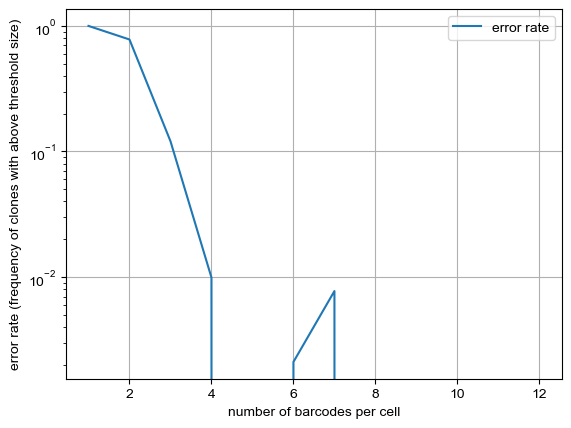

In [8]:
# Calculate and plot error rates
thresh_dist = y_value #above this distance the sisterhood would be considered to have an error
error_rate_num_bc = np.array([])

for num_barcodes in np.unique(filtered_df["n_called_barcodes"]):
    idx = (filtered_df["n_called_barcodes"] == num_barcodes) & (filtered_df["sisters_max_distance"] > 0)
    if filtered_df.loc[idx]["sisters_max_distance"].empty:
        continue
    
    error_rate = np.sum(filtered_df.loc[idx]["sisters_max_distance"] > thresh_dist)/len(filtered_df.loc[idx]["sisters_max_distance"])
    error_rate_num_bc = np.append(error_rate_num_bc, error_rate)

# Plot error rates
plt.figure()
x = np.setdiff1d(np.unique(filtered_df["n_called_barcodes"]), exception)
plt.plot(x, error_rate_num_bc, label='error rate')
plt.yscale("log")
plt.legend()
plt.ylabel('error rate (frequency of clones with above threshold size)')
plt.xlabel('number of barcodes per cell')
plt.grid(True)
plt.show()

   num_barcodes  error_rate
0             1    0.988390
1             2    0.627887
2             3    0.060467
3             4    0.003386
4             5    0.000242
5             6    0.000000
6             7    0.000000
7             8    0.000000
8             9    0.000000
9            10    0.000000


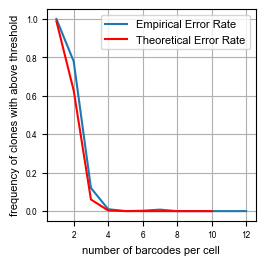

In [9]:
# Calculate cumulative error rates and theoretical error rates
error_rate_num_bc = np.array([])
percentage_more_than = np.array([])

for num_barcodes in np.unique(filtered_df["n_called_barcodes"]):
    idx = (filtered_df["n_called_barcodes"] ==num_barcodes) & (filtered_df["sisters_max_distance"] > 0)
    
    if filtered_df.loc[idx]["sisters_max_distance"].empty:
        exception = np.append(exception, num_barcodes)
        continue
    
    # Calculate empirical error rate
    error_rate = np.sum(filtered_df.loc[idx]["sisters_max_distance"] > thresh_dist) / len(filtered_df.loc[idx]["sisters_max_distance"])
    error_rate_num_bc = np.append(error_rate_num_bc, error_rate)
    
    # Calculate percentage of cells with more than current number of barcodes
    percentage = np.sum(idx) / len(filtered_df["n_called_barcodes"] >= 0)
    percentage_more_than = np.append(percentage_more_than, percentage)

# Calculate theoretical error rates
n = len(combined_df["barcode_names"].unique())
bc_lib_size = 96
error_rates = []



def compute_error_rate(barcodes, probabilities, num_initial_cells, sample_size=3):
    """
    Simulate sampling without replacement and compute error rate.
    Error rate = fraction of samples that are duplicates (unordered).
    """
    samples = [
        tuple(sorted(np.random.choice(barcodes, size=sample_size, replace=False, p=probabilities)))
        for _ in range(num_initial_cells)
    ]
    unique_samples = set(samples)
    n_duplicates = len(samples) - len(unique_samples)
    error_rate = n_duplicates / len(samples)
    return error_rate

# Generate barcode pool and abundance distribution
barcodes = np.array([f'bc_{i:03d}' for i in range(1, bc_lib_size+1)])  # 96 barcodes
barcode_df = pd.read_csv(os.path.join(data_folder, 'barcode_probabilities.csv'))
barcodes = barcode_df['barcode'].to_numpy()
probabilities = barcode_df['probability'].to_numpy()

# Iterate over sample sizes 1 through 11
results = []
for size in range(1, 11):
    error = compute_error_rate(barcodes, probabilities, num_initial_cells = int(np.max(combined_df['bc_cluster'])),sample_size=size)
    results.append((size, error))

# Create a results DataFrame
df_error_rates = pd.DataFrame(results, columns=["num_barcodes", "error_rate"])
print(df_error_rates)


# Plot empirical vs theoretical error rates
width_in = 7 / 2.54
height_in = 7 / 2.54

# Create figure of size 6 cm by 6 cm
fig, ax = plt.subplots(figsize=(width_in, height_in))
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.98)

x = np.setdiff1d(np.unique(filtered_df["n_called_barcodes"]), exception)
f1, = plt.plot(x, error_rate_num_bc, label='Empirical Error Rate')
f2, = plt.plot(range(1, 11), df_error_rates['error_rate'].values, 'r', label='Theoretical Error Rate')

ax.tick_params(axis='both', which='major', labelsize=6)

# Create legend with 8-pt text
ax.legend(fontsize=8,loc='upper right')

plt.ylabel('frequency of clones with above threshold', fontsize=8)
plt.xlabel('number of barcodes per cell',fontsize=8)
plt.grid(True)
plt.tight_layout()
# plt.savefig(os.path.join(output_folder, 'expected vs measured error rate.pdf'),bbox_inches="tight")
plt.show()

In [10]:
# Define different numbers of cells to simulate
cell_counts = [1000, 10000, 100000]

# Prepare results
multi_size_results = []

for n_cells in cell_counts:
    err_3 = compute_error_rate(barcodes, probabilities, num_initial_cells=n_cells, sample_size=3)
    err_4 = compute_error_rate(barcodes, probabilities, num_initial_cells=n_cells, sample_size=4)
    multi_size_results.append((n_cells, err_3, err_4))

# Create DataFrame
df_multi_size = pd.DataFrame(multi_size_results, columns=["number of initial cells", "error rate using 3 barcodes", "error rate using 4 barcodes"])
print(df_multi_size)

# Optional: Save to CSV
df_multi_size.to_csv(os.path.join(data_output_folder, 'error_rate_by_cell_number.csv'), index=False)


   number of initial cells  error rate using 3 barcodes  \
0                     1000                       0.0080   
1                    10000                       0.0726   
2                   100000                       0.4319   

   error rate using 4 barcodes  
0                      0.00200  
1                      0.00440  
2                      0.04294  


In [ ]:
import matplotlib.pyplot as plt
import os

# Format values
df_rounded = df_multi_size.copy()

# Format cell counts as integers (no decimal)
df_rounded["number of initial cells"] = df_rounded["number of initial cells"].astype(int)

# Convert error rates to percentages
df_rounded["error rate using 3 barcodes"] = (df_rounded["error rate using 3 barcodes"] * 100).round(1).astype(str) + "%"
df_rounded["error rate using 4 barcodes"] = (df_rounded["error rate using 4 barcodes"] * 100).round(1).astype(str) + "%"

# Rename columns with line breaks for better wrapping
df_rounded.columns = [
    "Number of\ninitial cells",
    "Error rate\n(3 barcodes)",
    "Error rate\n(4 barcodes)"
]

# Create figure
fig, ax = plt.subplots(figsize=(4.5, 1.6))
ax.axis('off')

# Create table
table = ax.table(
    cellText=df_rounded.values,
    colLabels=df_rounded.columns,
    loc='center',
    cellLoc='center',
    colLoc='center',
    bbox=[0, 0, 1, 1]
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.4)

# Fit column widths to headers
for i in range(len(df_rounded.columns)):
    table.auto_set_column_width(i)

# Save
plt.tight_layout()
plt.savefig(os.path.join(data_output_folder, "error_rate_table_percentage.pdf"), bbox_inches="tight")
plt.savefig(os.path.join(data_output_folder, "error_rate_table_percentage.svg"), bbox_inches="tight")
plt.show()


In [ ]:
x = np.setdiff1d(np.unique(filtered_df["n_called_barcodes"]), exception)
error_rate_num_bc = np.array([])
percentage_more_than = np.array([])
for num_barcodes in np.unique(filtered_df["n_called_barcodes"]):
    idx = (filtered_df["n_called_barcodes"] >= num_barcodes) & (filtered_df["sisters_max_distance"] > 0)
    
    if filtered_df.loc[idx]["sisters_max_distance"].empty:
        exception = np.append(exception, num_barcodes)
        continue
    
    # Calculate empirical error rate
    error_rate = np.sum(filtered_df.loc[idx]["sisters_max_distance"] > thresh_dist) / len(filtered_df.loc[idx]["sisters_max_distance"])
    error_rate_num_bc = np.append(error_rate_num_bc, error_rate)
    
    # Calculate percentage of cells with more than current number of barcodes
    percentage = np.sum(idx) / len(filtered_df["n_called_barcodes"] >= 0)
    percentage_more_than = np.append(percentage_more_than, percentage)

# Save error rate data
error_rate_df = pd.DataFrame({
    "num bc": x,
    "error_rate": error_rate_num_bc
})
error_rate_df.to_csv(os.path.join(data_output_folder, 'error_rate_equal_to_or_more.csv'))